In [122]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import NeuralNetwork, EstimatorQNN
from typing import Callable
from qiskit_algorithms.optimizers import Optimizer, OptimizerResult
from qiskit_machine_learning.algorithms import  BinaryObjectiveFunction, ObjectiveFunction
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.utils.loss_functions import L2Loss

algorithm_globals.random_seed = 39

In [123]:
#test data generation
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
print("X array values:", X)
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
print("y01 array values:", y01)
y = 2 * y01 - 1  # in {-1, +1}
print("y array values:", y)

X array values: [[ 0.00342391  0.07867081]
 [-0.7282516  -0.38722686]
 [ 0.15836936  0.58257328]
 [-0.69785203 -0.54167227]
 [ 0.88070001  0.33233499]
 [ 0.52926758  0.31859782]
 [-0.57602721 -0.53891531]
 [-0.55150683 -0.03623006]
 [ 0.1296793   0.95217273]
 [ 0.58789143 -0.76337303]
 [ 0.70652282 -0.44521557]
 [-0.49189997 -0.17115235]
 [ 0.55351714  0.6091215 ]
 [ 0.54404344  0.02215184]
 [-0.65334859 -0.23485136]
 [ 0.21341744 -0.27681208]
 [-0.52117712  0.62358466]
 [-0.94254614  0.11388921]
 [ 0.93903127 -0.06979892]
 [ 0.51850969 -0.52802687]]
y01 array values: [1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0]
y array values: [ 1 -1  1 -1  1  1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1  1 -1]


In [124]:
class CustomNeuralNetwork():
    def __init__(
        self,
        neural_network: NeuralNetwork,
        loss: str,
        optimizer: Optimizer,
        callback: Callable[[np.ndarray, float], None] | None = None,
    ):
        self.neural_network = neural_network
        if loss == "squared_error":
            self.loss = L2Loss()
        else:
            raise QiskitMachineLearningError(f"Unknown loss {loss}!")
        self.optimizer = optimizer
        self.callback = callback
        self.optimized_weights = OptimizerResult

    @property
    def weights(self) -> np.ndarray:
        return np.asarray(self.optimized_weights.x)

    def fit(self, X: np.ndarray, y: np.ndarray) -> OptimizerResult:
         function = BinaryObjectiveFunction(X, y, self.neural_network, self.loss)
         result = self.minimize(function)
         self.optimized_weights = result
         return result
     
    def minimize(self, function: ObjectiveFunction) -> OptimizerResult:
        objective = self.get_objective(function)
        initial_point = algorithm_globals.random.random(self.neural_network.num_weights)
        if callable(self.optimizer):
            optimizer_result = self.optimizer(
                fun=objective, 
                x0=initial_point, 
                jac=function.gradient
            )
        else:
            optimizer_result = self.optimizer.minimize(
                fun=objective,
                x0=initial_point,
                jac=function.gradient,
            )
        return optimizer_result
    
    def get_objective(self, function: ObjectiveFunction,) -> Callable:
        def objective(objective_weights):
            objective_value = function.objective(objective_weights)
            self.callback(objective_weights, objective_value)
            return objective_value

        return objective

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.sign(self.neural_network.forward(X, self.optimized_weights.x))

    def score(self, X: np.ndarray, y: np.ndarray, sample_weight: np.ndarray | None = None) -> float:
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

In [125]:
#function that plots objective function results.
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


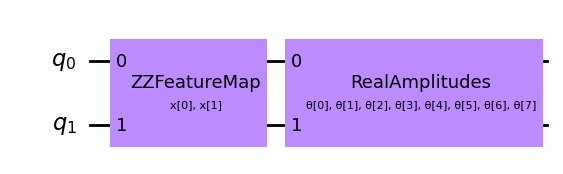

In [126]:
num_qubits = 2

feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits=num_qubits)
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qc.draw("mpl", style="clifford")

In [127]:
estimator_qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

custom_qnn = CustomNeuralNetwork(
    estimator_qnn, loss="squared_error", optimizer=COBYLA(maxiter=60), callback=callback_graph
)

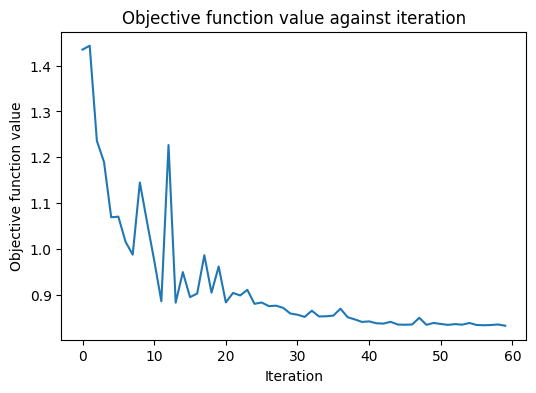

0.8

In [128]:
objective_func_vals = []
custom_qnn.fit(X, y)
custom_qnn.score(X, y)

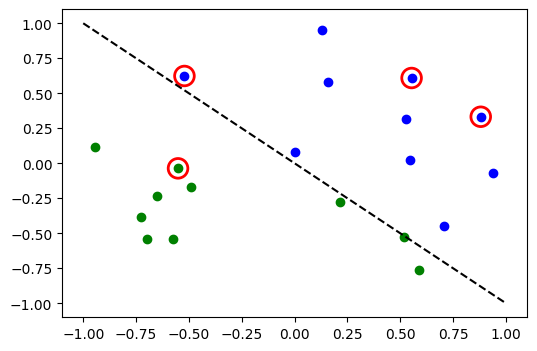

In [129]:
# evaluate data points
y_predict = custom_qnn.predict(X)

# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [130]:
custom_qnn.weights

array([ 0.38437608,  1.04718843,  2.22287295,  1.19472047,  0.3948117 ,
        2.29205195,  1.4296341 , -0.35051371])